    Forecast the Airlines Passengers data set. 
    Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. 
    Finally which model you will use for Forecasting.

### Importing the required Libraries

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from pandas import Grouper
from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing #SES
from statsmodels.tsa.holtwinters import Holt  # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# importing warnings
import warnings
warnings.filterwarnings("ignore")

#### Reading the dataset

In [2]:
airlines = pd.read_excel("Airlines+Data.xlsx")
airlines.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


### Performing EDA on the dataset

In [3]:
# to get the information of the datafile
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [4]:
# to check the null values of the data
airlines.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [5]:
print("Dimensions -",airlines.shape)
print("Column names -",airlines.columns)

Dimensions - (96, 2)
Column names - Index(['Month', 'Passengers'], dtype='object')


In [6]:
# Summarizing the dataset
airlines.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [7]:
# to check the dimensions of duplicates in the data
print(airlines[airlines.duplicated()].shape)

# to get the duplicate values from the data
airlines[airlines.duplicated()]

(0, 2)


,Month,Passengers


### Feature Engineering

In [8]:
# Renaming the 'Month' column as 'Date'
airlines.rename({'Month':'Date'},axis=1, inplace=True)

In [9]:
# making the Date column as DateTime Index for the dataframe
air1 = airlines.copy()
air1.set_index('Date',inplace=True)
print(air1.index.year)

air1.head()

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')


,Passengers
Date,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [10]:
# Now, extracting the month and year into seperate columns from the Date column
airlines["Date"] = pd.to_datetime(airlines.Date,format="%b-%y")
airlines["Month"] = airlines.Date.dt.strftime("%b") # month extraction
airlines["Year"] = airlines.Date.dt.strftime("%Y") # year extraction
airlines.head(12)

,Date,Passengers,Month,Year
0,1995-01-01,112,Jan,1995
1,1995-02-01,118,Feb,1995
2,1995-03-01,132,Mar,1995
3,1995-04-01,129,Apr,1995
4,1995-05-01,121,May,1995
5,1995-06-01,135,Jun,1995
6,1995-07-01,148,Jul,1995
7,1995-08-01,148,Aug,1995
8,1995-09-01,136,Sep,1995
9,1995-10-01,119,Oct,1995


## Visualizations 

##### Line Plot

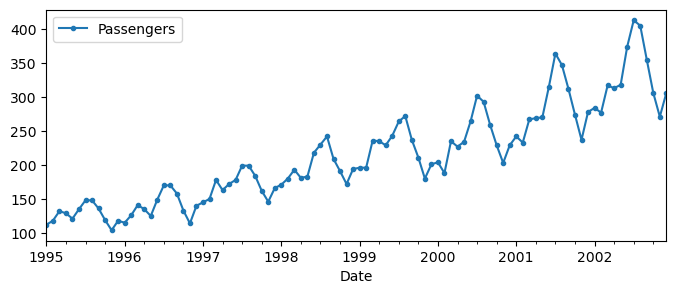

In [11]:
# creating a Line Plot
air1.plot(figsize=(8,3), marker='.')
plt.show()

We can observe that there is an increment in the trend.

Hence, the time series is non-stationary.

##### Histogram  Plot

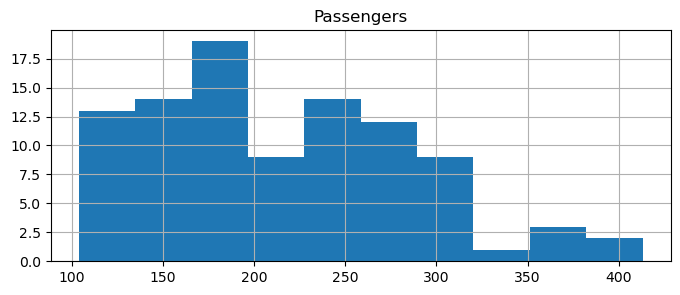

In [12]:
# Plotting a Histogram
air1.hist(figsize=(8,3))
plt.show()

##### Density Plot

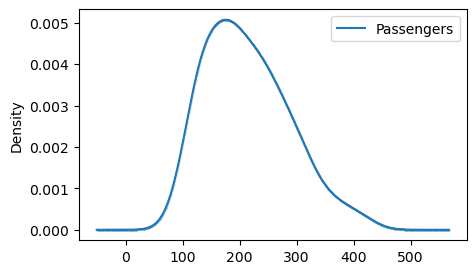

In [13]:
# creating Density Plot
air1.plot(kind='kde', figsize=(5,3), marker='.', markersize=0.3)
plt.show()

##### Box Plot

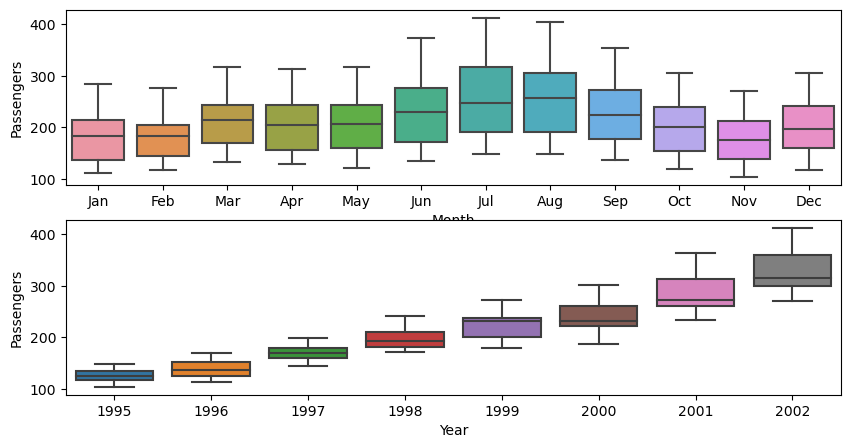

In [14]:
# Boxplot for each year by monthly intervals
plt.figure(figsize=(10,5))
plt.subplot(211)
sns.boxplot(x="Month", y="Passengers", data=airlines);
plt.subplot(212)
sns.boxplot(x="Year", y="Passengers", data=airlines);

##### Lag Plot

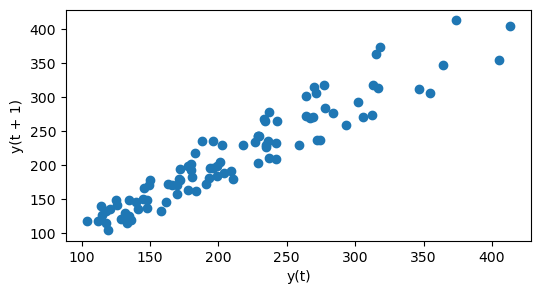

In [15]:
# creating Scatter Plot
plt.figure(figsize=(6,3))
lag_plot(air1)
plt.show()

### Moving Average

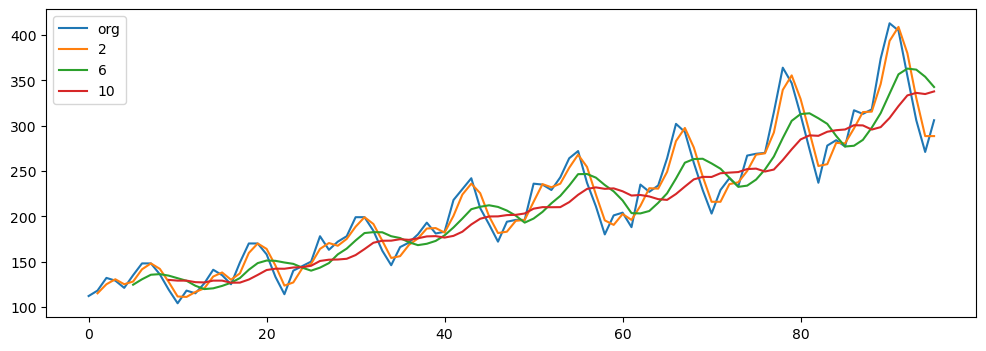

In [16]:
plt.figure(figsize=(12,4))
airlines.Passengers.plot(label='org')
for i in range(2,13,4):
    airlines['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.show()

#### Time series decomposition plot

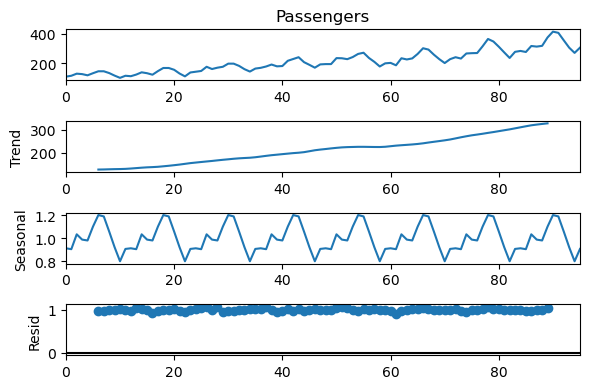

In [17]:
decomp = seasonal_decompose(airlines.Passengers, period=12, model="multiplicative")
with plt.rc_context():
    plt.rc("figure", figsize=(6,4))
    decomp.plot()
    plt.show()

#### Autocorrelation Plot (ACF)

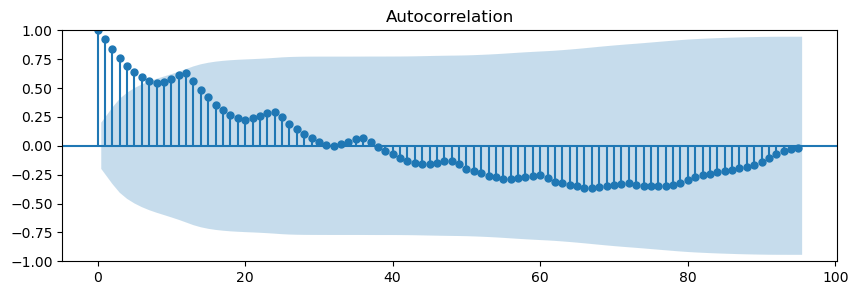

In [18]:
# creating an Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
with plt.rc_context():
    plt.rc("figure", figsize=(10,3))
    plot_acf(air1,lags=95)
    plt.show()

#### Partial Autocorrelation Plot (PACF)

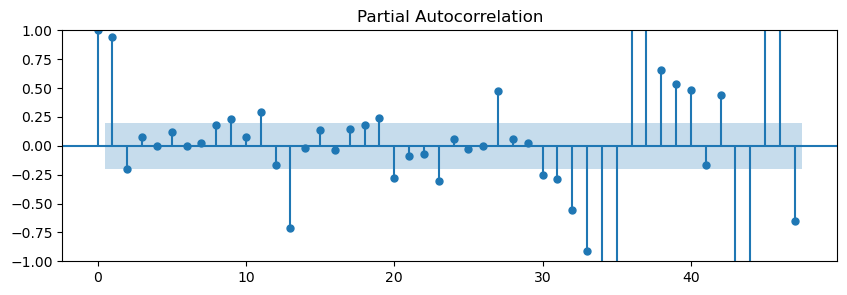

In [19]:
# creating an Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf
with plt.rc_context():
    plt.rc("figure", figsize=(10,3))
    plot_pacf(air1,lags=47)
    plt.show()

## Data Preprocessing

In [20]:
# getting dummies of the Month column and performing concatenation
month_dummies = pd.DataFrame(pd.get_dummies(airlines['Month']))
data = pd.concat([airlines, month_dummies],axis = 1)
data

,Date,Passengers,Month,Year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,1995,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,1995,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,1995,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1995,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,1995,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,Aug,2002,0,1,0,0,0,0,0,0,0,0,0,0
92,2002-09-01,355,Sep,2002,0,0,0,0,0,0,0,0,0,0,0,1
93,2002-10-01,306,Oct,2002,0,0,0,0,0,0,0,0,0,0,1,0
94,2002-11-01,271,Nov,2002,0,0,0,0,0,0,0,0,0,1,0,0


#### Applying Transformations

In [21]:
data["t"] = np.arange(1,97)
data["t_sq"] = data["t"]*data["t"]
data["log"] = np.log(data["Passengers"])

data.head()

,Date,Passengers,Month,Year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_sq,log
0,1995-01-01,112,Jan,1995,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,Feb,1995,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,Mar,1995,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,Apr,1995,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,May,1995,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791


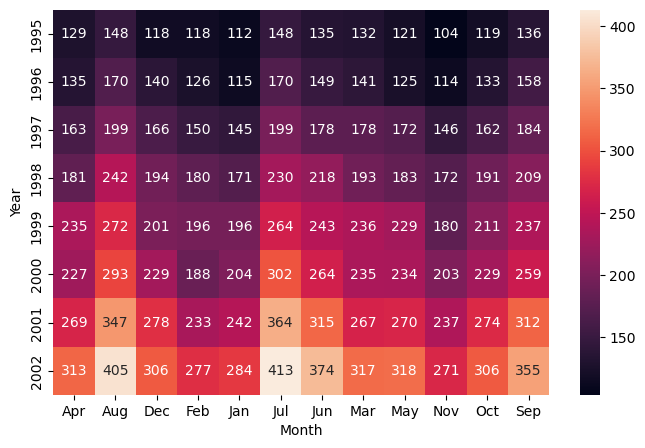

In [22]:
# plotting heatmap between months and years
plt.figure(figsize=(8,5))
Y_month = pd.pivot_table(data=data, values="Passengers", index="Year", 
                         columns="Month", aggfunc="mean", fill_value=0)
sns.heatmap(Y_month, annot=True, fmt="g");

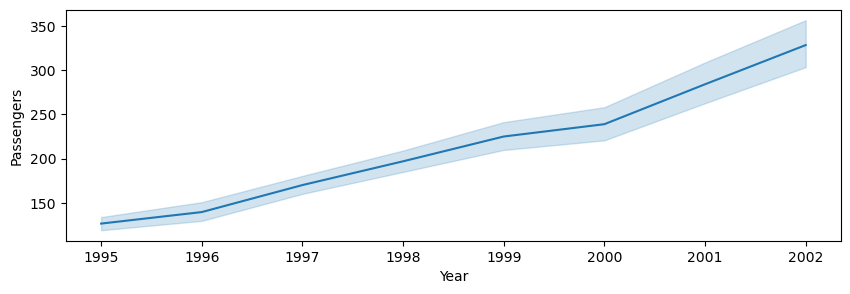

In [23]:
# creating lineplot
plt.figure(figsize=(10,3))
sns.lineplot(x="Year", y="Passengers", data=data);

So, from all the plots we can observe that the dataset has upward trend with multiplicative seasonality.

### Splitting the Data

In [24]:
# splitting the data into train and test data
train = data.head(80)
test = data.tail(16)

In [25]:
# printing the dimensions of the train and test data
print(train.shape)
print(test.shape) 

(80, 19)
(16, 19)


### Evaluation Metrics - RMSE & MAPE

In [26]:
def RMSE(pred, org):
    air = np.mean((pred-org)**2)
    return np.sqrt(air)

In [27]:
def MAPE(pred, org):
    air = np.abs(((pred-org)/org)*100)
    return np.mean(air)

# Building Models

### LINEAR MODEL

In [28]:
# Fitting the linear model and predicting
lin_model = smf.ols("Passengers~t", data=train).fit()
lin_pred = pd.Series(lin_model.predict(pd.DataFrame(test["t"])))
lin_pred

80    281.560759
81    283.736334
82    285.911908
83    288.087482
84    290.263057
85    292.438631
86    294.614205
87    296.789780
88    298.965354
89    301.140928
90    303.316503
91    305.492077
92    307.667651
93    309.843226
94    312.018800
95    314.194374
dtype: float64

In [29]:
# To get RMSE of the linear model
lin_rmse = RMSE(lin_pred, test['Passengers'])
print('RMSE of the Linear Model : ',lin_rmse)

# To get MAPE of the linear model
lin_mape = MAPE(lin_pred, test['Passengers'])
print('MAPE of the Linear Model : ',lin_mape)

RMSE of the Linear Model :  47.542624067726734
MAPE of the Linear Model :  10.412065149364267


### EXPONENTIAL MODEL

In [30]:
# Fitting the exponential model and predicting
exp_model = smf.ols("log~t", data=train).fit()
exp_pred = np.exp(pd.Series(exp_model.predict(pd.DataFrame(test["t"]))))
exp_pred

80    294.021373
81    297.385627
82    300.788376
83    304.230059
84    307.711123
85    311.232018
86    314.793200
87    318.395130
88    322.038274
89    325.723103
90    329.450095
91    333.219732
92    337.032502
93    340.888898
94    344.789420
95    348.734573
dtype: float64

In [31]:
# To get RMSE of the exponential model
exp_rmse = RMSE(exp_pred, test['Passengers'])
print('RMSE of the Exponential Model : ',exp_rmse)

# To get MAPE of the exponential model
exp_mape = MAPE(exp_pred, test['Passengers'])
print('MAPE of the Exponential Model : ',exp_mape)

RMSE of the Exponential Model :  43.79373939334322
MAPE of the Exponential Model :  11.472693597730526


### QUADRATIC MODEL

In [32]:
# Fitting the quadratic model and predicting
quad_model = smf.ols("Passengers ~ t+t_sq", data=train).fit()
quad_pred = pd.Series(quad_model.predict(pd.DataFrame(test[["t","t_sq"]])))
quad_pred

80    294.174684
81    297.284623
82    300.417351
83    303.572869
84    306.751176
85    309.952273
86    313.176159
87    316.422834
88    319.692299
89    322.984553
90    326.299596
91    329.637429
92    332.998052
93    336.381463
94    339.787664
95    343.216655
dtype: float64

In [33]:
# To get RMSE of the quadratic model
quad_rmse = RMSE(quad_pred, test['Passengers'])
print('RMSE of the Quadratic Model : ',quad_rmse)

# To get MAPE of the quadratic model
quad_mape = MAPE(quad_pred, test['Passengers'])
print('MAPE of the Quadratic Model : ',quad_mape)

RMSE of the Quadratic Model :  43.65440369584249
MAPE of the Quadratic Model :  11.238781999548236


## Exponential Smoothing

In [34]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### SIMPLE EXPONENTIAL METHOD

In [35]:
# Fitting the simple exponential model and predicting
sim_exp_m = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
sim_exp_pred = sim_exp_m.predict(start=test.index[0], end=test.index[-1])
sim_exp_pred

80    297.434175
81    297.434175
82    297.434175
83    297.434175
84    297.434175
85    297.434175
86    297.434175
87    297.434175
88    297.434175
89    297.434175
90    297.434175
91    297.434175
92    297.434175
93    297.434175
94    297.434175
95    297.434175
dtype: float64

In [36]:
# To get RMSE of the simple exponential model
sim_exp_rmse = RMSE(sim_exp_pred, test['Passengers'])
print('RMSE of the Simple Exponential Model : ',sim_exp_rmse)

# To get MAPE of the simple exponential model
sim_exp_mape = MAPE(sim_exp_pred, test['Passengers'])
print('MAPE of the Simple Exponential Model : ',sim_exp_mape)

RMSE of the Simple Exponential Model :  50.8582166265628
MAPE of the Simple Exponential Model :  11.375850554268187


### HOLT METHOD

In [37]:
# Fitting the model using HOLT method and predicting
holt_model = Holt(train["Passengers"]).fit(smoothing_trend=0.2)
holt_pred = holt_model.predict(start=test.index[0], end=test.index[-1])
holt_pred

80    359.391457
81    371.782913
82    384.174370
83    396.565826
84    408.957283
85    421.348739
86    433.740196
87    446.131652
88    458.523109
89    470.914565
90    483.306022
91    495.697478
92    508.088935
93    520.480391
94    532.871848
95    545.263304
dtype: float64

In [38]:
# To get RMSE of the model using holt method
holt_rmse = RMSE(holt_pred, test['Passengers'])
print('RMSE of the Holt Model : ',holt_rmse)

# To get MAPE of the model using holt method
holt_mape = MAPE(holt_pred, test['Passengers'])
print('MAPE of the Holt Model : ',holt_mape)

RMSE of the Holt Model :  148.51321272908092
MAPE of the Holt Model :  45.54089215221474


### HOLTS WINTER EXPONENTIAL SMOOTHENING 
    with multiplicative seasonality and additive trend

In [39]:
# Fitting the model using HOLTs winter exponential smoothening method and predicting
holt_exp_mm = ExponentialSmoothing(train["Passengers"], seasonal="mul", 
                                   trend="add", seasonal_periods=12).fit()
holt_exp_pred = holt_exp_mm.predict(start=test.index[0], end=test.index[-1])
holt_exp_pred

80    310.167151
81    273.377833
82    239.337752
83    270.781053
84    276.719785
85    274.057475
86    317.640783
87    307.796126
88    306.484846
89    343.879840
90    384.064821
91    379.427012
92    336.660094
93    296.563382
94    259.493859
95    293.426269
dtype: float64

In [40]:
# To get RMSE of the model using holts exponential method
holt_exp_m_rmse = RMSE(holt_exp_pred, test['Passengers'])
print('RMSE of the Holts Exponential Smoothening(mul) Model : ',holt_exp_m_rmse)

# To get MAPE of the model using holts exponential method
holt_exp_m_mape = MAPE(holt_exp_pred, test['Passengers'])
print('MAPE of the Holt Exponential Smoothening(mul) Model : ',holt_exp_m_mape)

RMSE of the Holts Exponential Smoothening(mul) Model :  14.5718321244179
MAPE of the Holt Exponential Smoothening(mul) Model :  3.2180043767082425


### HOLTS WINTER EXPONENTIAL SMOOTHENING
    with additive seasonality and additive trend

In [41]:
# Fitting the model using HOLTs winter exponential smoothening method and predicting
holt_exp_am = ExponentialSmoothing(train["Passengers"], seasonal="add", 
                                   trend="add", seasonal_periods=12).fit()
holt_exp_pred = holt_exp_am.predict(start=test.index[0], end=test.index[-1])
holt_exp_pred

80    325.222032
81    302.227254
82    281.227768
83    302.726262
84    306.824873
85    307.678042
86    334.962471
87    328.818672
88    328.101861
89    352.103221
90    377.103859
91    376.250044
92    353.000976
93    330.006199
94    309.006712
95    330.505206
dtype: float64

In [42]:
# To get RMSE of the model using holts exponential method
holt_exp_a_rmse = RMSE(holt_exp_pred, test['Passengers'])
print('RMSE of the Holts Exponential Smoothening(add) Model : ',holt_exp_a_rmse)

# To get MAPE of the model using holts exponential method
holt_exp_a_mape = MAPE(holt_exp_pred, test['Passengers'])
print('MAPE of the Holt Exponential Smoothening(add) Model : ',holt_exp_a_mape)

RMSE of the Holts Exponential Smoothening(add) Model :  26.095976386944315
MAPE of the Holt Exponential Smoothening(add) Model :  7.949424050264893


## Seasonalities

### ADDITIVE SEASONALITY

In [43]:
# Fitting the model using additive seasonality and predicting
adds_model = smf.ols("Passengers ~ Apr+Aug+Dec+Feb+Jan+Jul+Jun+Mar+May+Nov+Oct+Sep", data=train).fit()
adds_pred = pd. Series(adds_model.predict(pd.DataFrame(test[['Apr','Aug','Dec','Feb','Jan','Jul',
                                                             'Jun','Mar','May','Nov','Oct','Sep']])))
adds_pred

80    197.166667
81    174.166667
82    153.166667
83    174.666667
84    169.285714
85    170.142857
86    197.428571
87    191.285714
88    190.571429
89    214.571429
90    239.571429
91    238.714286
92    197.166667
93    174.166667
94    153.166667
95    174.666667
dtype: float64

In [44]:
# To get RMSE of the model using additive seasonality
adds_rmse = RMSE(adds_pred, test['Passengers'])
print('RMSE of the Additive Seasonality Model : ',adds_rmse)

# To get MAPE of the model using additive seasonality 
adds_mape = MAPE(adds_pred, test['Passengers'])
print('MAPE of the Additive Seasonality Model : ',adds_mape)

RMSE of the Additive Seasonality Model :  129.26647641443304
MAPE of the Additive Seasonality Model :  40.06579252693331


### ADDITIVE SEASONALITY WITH QUADRATIC TREND

In [45]:
# Fitting the model using additive seasonality with quadratic trend and predicting
adds_quad_m = smf.ols("Passengers ~ t+t_sq+Apr+Aug+Dec+Feb+Jan+Jul+Jun+Mar+May+Nov+Oct+Sep", data=train).fit()
adds_quad_pred = pd.Series(adds_quad_m.predict(pd.DataFrame(test[["t","t_sq",'Apr', 'Aug', 'Dec', 
                                                                  'Feb', 'Jan','Jul', 'Jun', 'Mar', 
                                                                  'May', 'Nov', 'Oct', 'Sep']])))
adds_quad_pred

80    295.660188
81    273.296441
82    252.932693
83    275.068946
84    281.849739
85    283.434027
86    311.446888
87    306.031176
88    306.044037
89    330.771183
90    356.498328
91    356.368332
92    329.618361
93    307.436401
94    287.254440
95    309.572479
dtype: float64

In [46]:
# To get RMSE of the model using additive seasonality with quadratic trend
adds_quad_rmse = RMSE(adds_quad_pred, test['Passengers'])
print('RMSE of the Additive Seasonality (Quad Trend) Model : ',adds_quad_rmse)

# To get MAPE of the model using additive seasonality with quadratic trend
adds_quad_mape = MAPE(adds_quad_pred, test['Passengers'])
print('MAPE of the Additive Seasonality (Quad Trend) Model : ',adds_quad_mape)

RMSE of the Additive Seasonality (Quad Trend) Model :  23.91098357010903
MAPE of the Additive Seasonality (Quad Trend) Model :  4.757528367244028


### MULTIPLICATIVE SEASONALITY 

In [47]:
# Fitting the model using multiplicative seasonality and predicting
muls_model = smf.ols("log ~ Apr+Aug+Dec+Feb+Jan+Jul+Jun+Mar+May+Nov+Oct+Sep", data=train).fit()
muls_pred = np.exp(pd.Series(muls_model.predict(pd.DataFrame(test[['Apr','Aug','Dec','Feb',
                                                                       'Jan','Jul','Jun','Mar',
                                                                       'May','Nov','Oct','Sep']]))))
muls_pred

80    192.398361
81    169.438001
82    148.855427
83    170.408754
84    163.250497
85    165.816061
86    191.568046
87    184.843888
88    183.056135
89    206.057385
90    229.388674
91    229.474806
92    192.398361
93    169.438001
94    148.855427
95    170.408754
dtype: float64

In [48]:
# To get RMSE of the model using multiplicative seasonality
muls_rmse = RMSE(muls_pred, test['Passengers'])
print('RMSE of the Multiplicative Seasonality Model : ',muls_rmse)

# To get MAPE of the model using multiplicative seasonality 
muls_mape = MAPE(muls_pred, test['Passengers'])
print('MAPE of the Multiplicative Seasonality Model : ',muls_mape)

RMSE of the Multiplicative Seasonality Model :  135.32648414621062
MAPE of the Multiplicative Seasonality Model :  41.90680946153699


### MULTIPLICATIVE ADDITIVE SEASONALITY 

In [49]:
# Fitting the model using multiplicative additive seasonality and predicting
mul_adds_m = smf.ols("log ~ t+Apr+Aug+Dec+Feb+Jan+Jul+Jun+Mar+May+Nov+Oct+Sep", data=train).fit()
mul_adds_pred = np.exp(pd.Series(mul_adds_m.predict(pd.DataFrame(test[["t",'Apr','Aug','Dec','Feb',
                                                                        'Jan','Jul','Jun','Mar',
                                                                        'May','Nov','Oct','Sep']]))))
mul_adds_pred

80    307.323808
81    270.648521
82    237.771343
83    272.199133
84    278.808336
85    283.189950
86    327.170631
87    315.686737
88    312.633514
89    351.916335
90    391.762817
91    391.909918
92    351.324969
93    309.398688
94    271.814312
95    311.171310
dtype: float64

In [50]:
# To get RMSE of the model using multiplicative seasonality
mul_adds_rmse = RMSE(mul_adds_pred, test['Passengers'])
print('RMSE of the Multiplicative Additive Seasonality Model : ',mul_adds_rmse)

# To get MAPE of the model using multiplicative seasonality 
mul_adds_mape = MAPE(mul_adds_pred, test['Passengers'])
print('MAPE of the Multiplicative Additve Seasonality Model : ',mul_adds_mape)

RMSE of the Multiplicative Additive Seasonality Model :  9.469000230375839
MAPE of the Multiplicative Additve Seasonality Model :  2.0854045449176715


## ARIMA MODEL

In [51]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [52]:
# making the Date column as DateTime Index for the dataframe
data1 = data.copy()
data1.set_index('Date',inplace=True)
data1.reset_index(inplace=True)
data1.head()

,Date,Passengers,Month,Year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_sq,log
0,1995-01-01,112,Jan,1995,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,Feb,1995,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,Mar,1995,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,Apr,1995,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,May,1995,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791


            Passengers
Date                  
1995-01-01         112
1995-02-01         118
1995-03-01         132
1995-04-01         129
1995-05-01         121


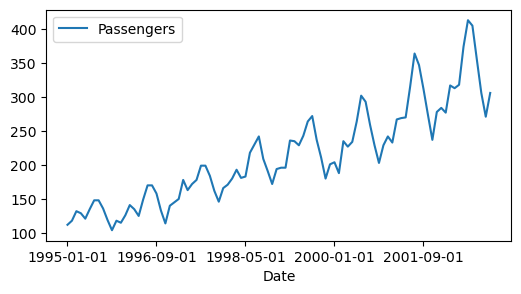

In [53]:
# Making the data as stationary and printing 
data2 = data1[["Date", "Passengers"]]
data2.to_csv("data3.csv", index=False)
df = pd.read_csv("data3.csv", index_col=0)
print(df.head())
# visualizing
df.plot(figsize=(6,3))
plt.show()

In [54]:
# Evaluating the data
testr = adfuller(df['Passengers'])

Null Hypothesis Ho : It is non-stationary

Alter Hypothesis H1 : It is stationary

In [55]:
def adfuller_test(Passengers):
    result=adfuller(Passengers)
    labels = ['ADF Test Statistic','p-value','Lags Used','No. of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), So reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(df['Passengers'])

ADF Test Statistic : 1.3402479596466974
p-value : 0.9968250481137263
Lags Used : 12
No. of Observations Used : 83
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Transformations

In [56]:
# Applying the Transformations on the data

# Logarithm
df['log'] = np.log(df['Passengers'])
print('LOG : \n\n',df.head(),'\n')
print(adfuller_test(df['log'])) 
# ignore None in the output as it's resulting due to printing 

# Square Root
df['sqrt'] = np.sqrt(df['Passengers'])
print('\n\n\nSQRT : \n\n',df.head(),'\n')
print(adfuller_test(df['sqrt']))

# Combination of SquareRoot and Log
df['log_sq'] = np.sqrt(df['Passengers'])
print('\n\n\nCombination of SQRT & LOG : \n\n',df.head(),'\n')
adfuller_test(df['log_sq'])

LOG : 

             Passengers       log
Date                            
1995-01-01         112  4.718499
1995-02-01         118  4.770685
1995-03-01         132  4.882802
1995-04-01         129  4.859812
1995-05-01         121  4.795791 

ADF Test Statistic : -0.7230267542465467
p-value : 0.8406945968114725
Lags Used : 12
No. of Observations Used : 83
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
None



SQRT : 

             Passengers       log       sqrt
Date                                       
1995-01-01         112  4.718499  10.583005
1995-02-01         118  4.770685  10.862780
1995-03-01         132  4.882802  11.489125
1995-04-01         129  4.859812  11.357817
1995-05-01         121  4.795791  11.000000 

ADF Test Statistic : 0.4514346431262349
p-value : 0.983319798174552
Lags Used : 12
No. of Observations Used : 83
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [57]:
# Differencing
df['Seasonal_Diff'] = df['Passengers']-df['Passengers'].shift(12)
print('\n\n\nSeasonal Difference : \n\n',df.head(15),'\n')
print(adfuller_test(df['Seasonal_Diff'].dropna()))

# Sqrt transform with Differencing
df['sq_diff'] = df['sqrt']-df['sqrt'].shift(12)
print('\n\n\nSQRT trnasform with Seasonal Difference : \n\n',df.head(15),'\n')
adfuller_test(df['sq_diff'].dropna())




Seasonal Difference : 

             Passengers       log       sqrt     log_sq  Seasonal_Diff
Date                                                                 
1995-01-01         112  4.718499  10.583005  10.583005            NaN
1995-02-01         118  4.770685  10.862780  10.862780            NaN
1995-03-01         132  4.882802  11.489125  11.489125            NaN
1995-04-01         129  4.859812  11.357817  11.357817            NaN
1995-05-01         121  4.795791  11.000000  11.000000            NaN
1995-06-01         135  4.905275  11.618950  11.618950            NaN
1995-07-01         148  4.997212  12.165525  12.165525            NaN
1995-08-01         148  4.997212  12.165525  12.165525            NaN
1995-09-01         136  4.912655  11.661904  11.661904            NaN
1995-10-01         119  4.779123  10.908712  10.908712            NaN
1995-11-01         104  4.644391  10.198039  10.198039            NaN
1995-12-01         118  4.770685  10.862780  10.862780        

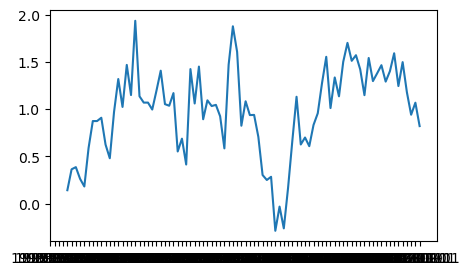

In [58]:
plt.figure(figsize=(5,3))
plt.plot(df['sq_diff'])
plt.show()

#### Splitting the Data

In [59]:
# Splitting the data

df1 = pd.read_csv("data3.csv", index_col=0)
split_point = len(df1)-12
dataset, validation = df1[0:split_point], df1[split_point:]
print("Dataset: %d, Validation: %d" % (len(dataset), len(validation)))

dataset.to_csv("dataset.csv", header=False)
validation.to_csv("validation.csv", header=False)

Dataset: 84, Validation: 12


#### Base Model

In [60]:
# Persistence / Base Model

train = pd.read_csv("dataset.csv", header=None, index_col=0,
                     parse_dates=True, squeeze=True)
X = train.values
X = X.astype("float32")
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

history = [X for X in train]
predictions = list()
for i in range (len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs) 
    print("Predicted: %.3f, Expected: %.3f" % (yhat, obs))
        
rmse = sqrt(mean_squared_error(test, predictions))
print("\nRMSE: %.3f" % rmse)

Predicted: 218.000, Expected: 230.000
Predicted: 230.000, Expected: 242.000
Predicted: 242.000, Expected: 209.000
Predicted: 209.000, Expected: 191.000
Predicted: 191.000, Expected: 172.000
Predicted: 172.000, Expected: 194.000
Predicted: 194.000, Expected: 196.000
Predicted: 196.000, Expected: 196.000
Predicted: 196.000, Expected: 236.000
Predicted: 236.000, Expected: 235.000
Predicted: 235.000, Expected: 229.000
Predicted: 229.000, Expected: 243.000
Predicted: 243.000, Expected: 264.000
Predicted: 264.000, Expected: 272.000
Predicted: 272.000, Expected: 237.000
Predicted: 237.000, Expected: 211.000
Predicted: 211.000, Expected: 180.000
Predicted: 180.000, Expected: 201.000
Predicted: 201.000, Expected: 204.000
Predicted: 204.000, Expected: 188.000
Predicted: 188.000, Expected: 235.000
Predicted: 235.000, Expected: 227.000
Predicted: 227.000, Expected: 234.000
Predicted: 234.000, Expected: 264.000
Predicted: 264.000, Expected: 302.000
Predicted: 302.000, Expected: 293.000
Predicted: 2

#### Building the Model based on the optimized values

In [61]:
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
df = train.values
df = df.astype("float32")
test = pd.read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

In [62]:
arima_model = ARIMA(df, order=(0,1,4)).fit()
forecast = arima_model.forecast(steps=12)
forecast

array([295.33620845, 296.53910693, 298.42477107, 286.39466484,
       286.39466484, 286.39466484, 286.39466484, 286.39466484,
       286.39466484, 286.39466484, 286.39466484, 286.39466484])

In [63]:
# To get RMSE of the ARIMA model
arima_rmse= RMSE(forecast, test[1])
print('RMSE of the ARIMA Model : ',arima_rmse)

# To get MAPE of the ARIMA model
arima_mape = MAPE(forecast, test[1])
print('MAPE of the ARIMA Model : ',arima_mape)

RMSE of the ARIMA Model :  12.817148674643901
MAPE of the ARIMA Model :  4.3276796022177555


## Conclusion 

In [64]:
Final = pd.DataFrame({"Model": pd.Series(["linear", "exponential", "quadratic", "simple exponential",
                                          "holt", "holt exponential (Multi)", "holt exponential (add)",
                                          "additive seas", "additive seas with quad", 
                                          "multiplicative seas","multiplicative additive seas","ARIMA"]),
                      "RMSE": pd.Series([lin_rmse, exp_rmse, quad_rmse, sim_exp_rmse, 
                                         holt_rmse, holt_exp_m_rmse, holt_exp_a_rmse, adds_rmse,
                                         adds_quad_rmse, muls_rmse, mul_adds_rmse, arima_rmse]),
                      "MAPE": pd.Series([lin_mape, exp_mape, quad_mape, sim_exp_mape, 
                                         holt_mape, holt_exp_m_mape, holt_exp_a_mape, adds_mape,
                                         adds_quad_mape, muls_mape, mul_adds_mape, arima_mape])})
Final.sort_values(["RMSE"])

,Model,RMSE,MAPE
10,multiplicative additive seas,9.469000,2.085405
11,ARIMA,12.817149,4.327680
5,holt exponential (Multi),14.571832,3.218004
8,additive seas with quad,23.910984,4.757528
6,holt exponential (add),26.095976,7.949424
2,quadratic,43.654404,11.238782
1,exponential,43.793739,11.472694
0,linear,47.542624,10.412065
3,simple exponential,50.858217,11.375851
7,additive seas,129.266476,40.065793


    We can observe that the model built with 'Multiplicative Additive Seasonality' method gives the best RMSE and MAPE Values.
    Hence, we can conclude that this is the best fit model for Forecasting the Airlines Passengers dataset.